In [6]:

import numpy as np
import pandas as pd
import os

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [7]:
# !unzip image_data.zip

Read Files

In [8]:
import os
# fake_images_path = os.path.join('data', 'train', 'FAKE')
# real_images_path = os.path.join('data', 'train', 'REAL')

# fake_images_count = len(os.listdir(fake_images_path))
# print(f"Total fake images: {fake_images_count}")

# real_images_count = len(os.listdir(real_images_path))
# print(f"Total real images: {real_images_count}")

# Google Colab
fake_images_path = os.path.join('image_data', 'train', 'FAKE')
real_images_path = os.path.join('image_data', 'train', 'REAL')


Location of all the images

In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Point to the parent directory
data_dir = os.path.join('image_data')

# Create training and validation datasets
train_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

val_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

print(train_ds.class_names)


Found 120000 files belonging to 2 classes.
Using 96000 files for training.
Found 120000 files belonging to 2 classes.
Using 24000 files for validation.
['test', 'train']


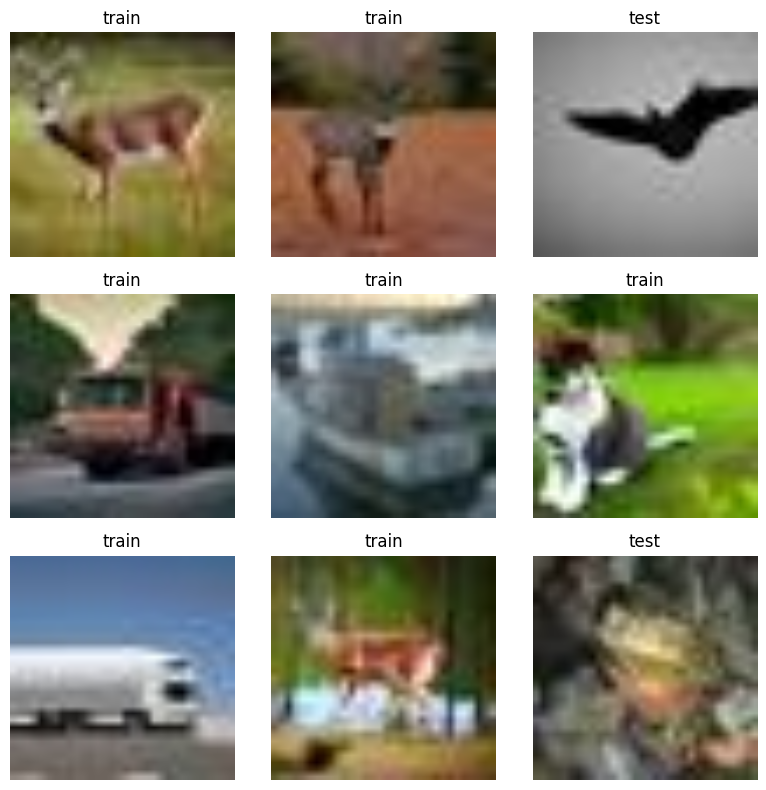

In [12]:
import matplotlib.pyplot as plt

for imgs, labels in train_ds.take(1):
    imgs = imgs.numpy().astype("uint8")
    labels = labels.numpy().astype(int)
    break

plt.figure(figsize=(8,8))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(imgs[i])
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")
plt.tight_layout()
plt.show()


Optimize the pipeline

In [13]:
AUTOTUNE = tf.data.AUTOTUNE
# Prefetch for performance
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


Data Augmentation

In [14]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

CNN

In [20]:
# from tensorflow.keras import layers, models

# model = models.Sequential([
#     layers.Rescaling(1./255, input_shape=(224, 224, 3)),
#     data_augmentation,

#     layers.Conv2D(32, (3,3), activation='relu'),
#     layers.MaxPooling2D(),

#     layers.Conv2D(64, (3,3), activation='relu'),
#     layers.MaxPooling2D(),

#     layers.Conv2D(128, (3,3), activation='relu'),
#     layers.MaxPooling2D(),

#     layers.Flatten(),
#     layers.Dropout(0.5),
#     layers.Dense(128, activation='relu'),
#     layers.Dense(1, activation='sigmoid')                # binary output
# ])
# model.summary()

import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Input(shape=(*IMG_SIZE, 3)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

Train with callbacks

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True)
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1891/6000 ━━━━━━━━━━━━━━━━━━━━ 35:15 515ms/step - accuracy: 0.8327 - loss: 0.4690

Plot all the curves

In [ ]:
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']
epochs   = range(1, len(acc)+1)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(epochs, acc,    label='train acc')
plt.plot(epochs, val_acc, label='val acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss,     label='train loss')
plt.plot(epochs, val_loss, label='val loss')
plt.title('Loss')
plt.legend()

plt.show()
